In [1]:
import pandas as pd
import country_converter as coco 
import re
import numpy as np
from fuzzywuzzy import process
import time
import io
import contextlib
import matplotlib.pyplot as plt

C:\Users\zheng\miniconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv("hosts_2025_05_20_1747761789.csv")
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing)
df = df.fillna('')


Missing values per column:
Self Describe Gender        5048
Disabilities Description    4845
Verification Status         3688
Description                 2920
Cleaning Frequency          2281
Visit Frequency             1659
Cooking Frequency           1659
Noise Tolerance             1659
Province                    1570
Country                     1558
Postal Code                 1541
Prefer Live With            1086
Gender                      1038
City                         561
Phone Number                  44
Schedules                     15
Disabilities                   0
ID                             0
Name                           0
Registered At                  0
Client Name                    0
Profile Status                 0
Email                          0
Is Deleted                     0
dtype: int64


In [3]:
cc = coco.CountryConverter()
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    df['Country_cleaned'] = cc.convert(names=df['Country'], to='name_short')

# Replace "not found" with "Unknown"
df['Country_cleaned'] = df['Country_cleaned'].replace('not found', 'Unknown')

In [4]:
df['Country_cleaned'].value_counts()

Country_cleaned
Canada            3469
Unknown           1591
United States        4
India                2
United Kingdom       1
Nepal                1
Estonia              1
Cameroon             1
Philippines          1
Name: count, dtype: int64

In [5]:
canonical_names = {
    'British Columbia': 'BC',
    'Alberta': 'AB',
    'Saskatchewan': 'SK',
    'Manitoba': 'MB',
    'Ontario': 'ON',
    'Quebec': 'QC',
    'Nova Scotia': 'NS',
    'New Brunswick': 'NB',
    'Newfoundland and Labrador': 'NL',
    'Prince Edward Island': 'PE',
    'Yukon': 'YT',
    'Northwest Territories': 'NT',
    'Nunavut': 'NU'
}

abbreviations = set(canonical_names.values())

# Step 1: Clean input
def clean_text(x):
    if pd.isnull(x):
        return ''
    return re.sub(r'[^\w\s]', '', str(x)).strip().lower()

df['Province_cleaned'] = df['Province'].apply(clean_text)

# Step 2: Match cleaned text
def fuzzy_match_to_abbr(name):
    if not name:
        return 'Unknown'
    
    # First: try direct abbreviation match
    if name.upper() in abbreviations:
        return name.upper()
    
    # Then: fuzzy match to canonical names
    result = process.extractOne(name, canonical_names.keys(), score_cutoff=80)
    if result is None:
        return 'Unknown'
    
    match, score = result
    return canonical_names.get(match, 'Unknown')

# Step 3: Apply matching
df['Province_cleaned'] = df['Province_cleaned'].apply(fuzzy_match_to_abbr)

df['Province_cleaned'].value_counts()

Province_cleaned
BC         1634
Unknown    1575
ON          789
NS          694
AB          315
QC           22
NB           21
MB            9
PE            5
NT            2
NL            2
SK            1
YT            1
NU            1
Name: count, dtype: int64

In [6]:
def clean_city(city):
    if pd.isnull(city):
        return 'Unknown'

    # Convert to lowercase and strip whitespace
    city = city.strip().lower()

    # Remove known province abbreviations and country names
    remove_terms = [' bc', ' ns', ' nb', ' qc', ' on', ' ab', ' pe', ' sk', ' nl', ' mb',
                    ' ohio', ' canada']
    for term in remove_terms:
        city = city.replace(term, '')

    # If address contains numbers (like full address), remove everything before last word
    city = re.sub(r'\d+', '', city)
    city = city.split(',')[-1].strip()  # Get city after comma if exists

    # Remove multi-word locations to last part (like Castlegar from full address)
    words = city.split()
    if len(words) > 2:
        city = words[-1]  # last word as a proxy for city

    # Capitalize each word
    city = ' '.join(w.capitalize() for w in city.split())

    return city

df['City_cleaned'] = df['City'].apply(clean_city)
df['City_cleaned'].value_counts()

City_cleaned
Kelowna           687
                  572
Halifax           296
Toronto           205
Calgary           134
                 ... 
Yorkton             1
Galiano Island      1
Fruitvale           1
Manotick            1
Mont-tremblant      1
Name: count, Length: 714, dtype: int64

In [7]:
import geonamescache

# Load geonames city data
gc = geonamescache.GeonamesCache()
cities = gc.get_cities()

# Define function to check and standardize city names
def validate_or_unknown(city_name):
    if pd.isna(city_name) or not str(city_name).strip():
        return 'Unknown'
    city_name_clean = str(city_name).strip().lower()
    if any(city['name'].lower() == city_name_clean for city in cities.values()):
        return city_name.strip()  # Return original cleaned name
    return 'Unknown'

# Example: apply to your dataframe column
df['City_cleaned'] = df['City_cleaned'].apply(validate_or_unknown)

In [8]:
df['City_cleaned'].value_counts()

City_cleaned
Unknown      1656
Kelowna       687
Halifax       296
Toronto       205
Calgary       134
             ... 
Norwood         1
Dieppe          1
Sherwood        1
Kathmandu       1
Cochrane        1
Name: count, Length: 214, dtype: int64

In [9]:
df['City_cleaned'].unique()

array(['Unknown', 'Burlington', 'Kelowna', 'Vernon', 'Penticton',
       'Toronto', 'Nanaimo', 'Edmonton', 'West Kelowna', 'Victoria',
       'Kamloops', 'Prince George', 'Abbotsford', 'Vancouver', 'Burnaby',
       'Chilliwack', 'Oyama', 'Surrey', 'Port Moody', 'North Vancouver',
       'Langley', 'Delta', 'Nelson', 'Mission', 'West Vancouver',
       'White Rock', 'Langford', 'New Westminster', 'Charlottetown',
       'London', 'Westminster', 'Richmond', 'Rosedale', 'Sidney',
       'Coquitlam', 'Calgary', 'Red Deer', 'Kathmandu', 'Airdrie',
       'Grande Prairie', 'Lethbridge', 'Courtenay', 'Delhi', 'Brampton',
       'Pitt Meadows', 'Anchorage', 'Leduc', 'Yorkton',
       'Dollard-des Ormeaux', 'Winnipeg', 'Mississauga', 'Pickering',
       'Kitchener', 'Seguin', 'Grand Forks', 'Maitland', 'Collingwood',
       'Saint John', 'Campbell River', 'Ottawa', 'Laval', 'Hamilton',
       'Scarborough', 'Longueuil', 'Windsor', 'Vaughan', 'Milton',
       'Richmond Hill', 'Maple Ridge', 'Br

In [10]:
df = df.drop(columns=['Name', 'Email', 'Phone Number', 'Postal Code', 'Verification Status', 'Self Describe Gender', 'Schedules'])

In [11]:
print(df.head())
print(df.info())
print(df.describe(include='all'))

    ID Profile Status Client Name Province         City      Country  \
0  136         Active    Happipad       BC  rishijainit  rishijainit   
1  137         Active    Happipad       BC   Burlington       Canada   
2  138         Active    Happipad               Kelowna       Canada   
3  139         Active    Happipad       BC      Kelowna       Canada   
4  140         Active    Happipad               Kelowna       Canada   

  Registered At Is Deleted  Gender Prefer Live With Noise Tolerance  \
0    2019-07-03         No    male             male      quiet_time   
1    2019-07-03         No  female           female      quiet_time   
2    2019-07-03         No                                            
3    2019-07-03         No    male    no_preference    not_too_loud   
4    2019-07-04         No                                            

  Disabilities Disabilities Description Cleaning Frequency Cooking Frequency  \
0          Yes                                              

In [15]:
df.replace(
    to_replace=['Unknown', 'NA', 'NaN', '', 'None'],
    value=np.nan,
    inplace=True
)

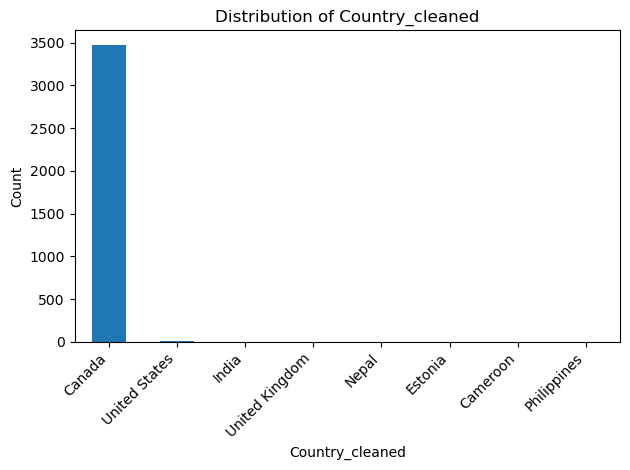

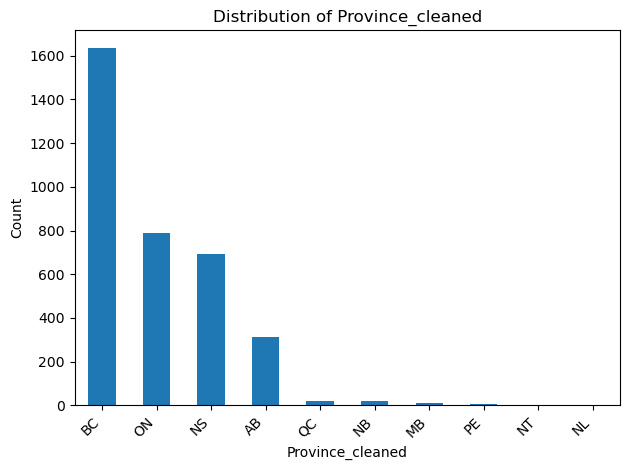

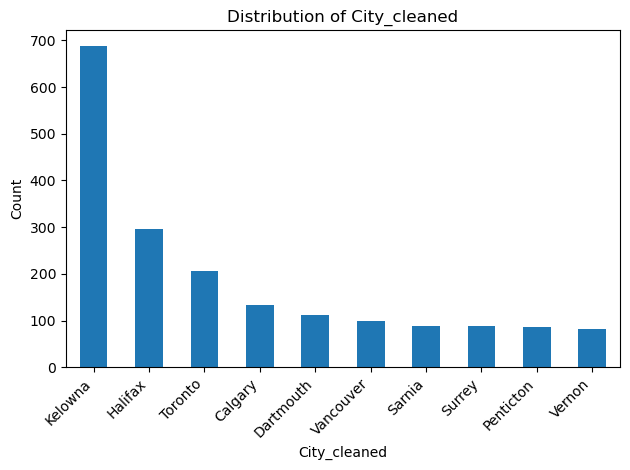

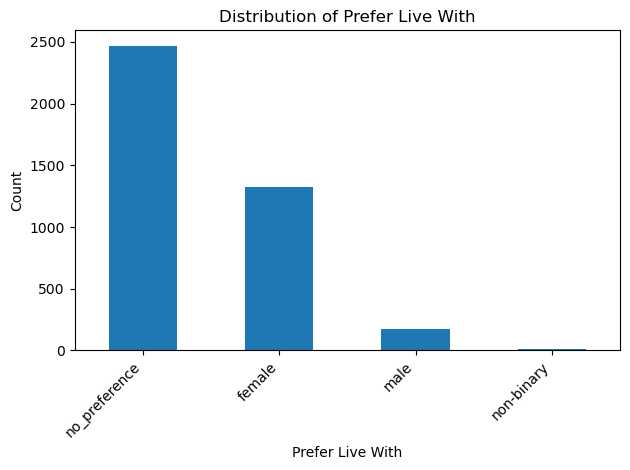

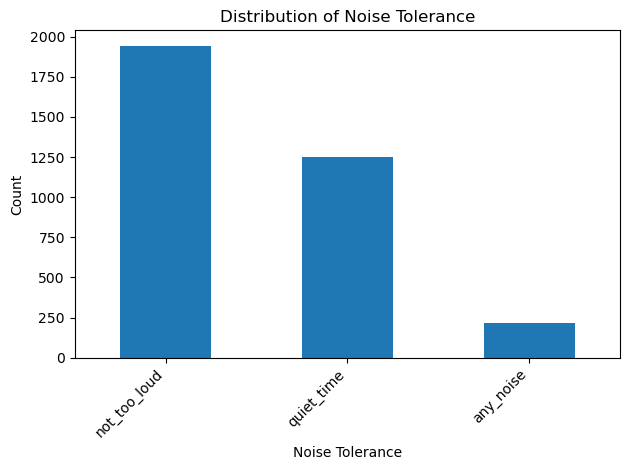

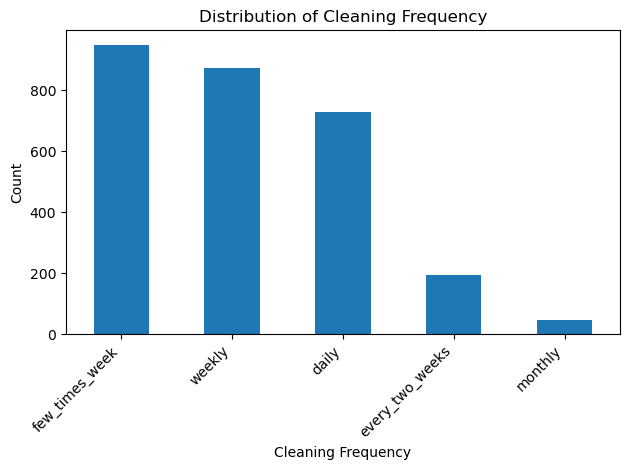

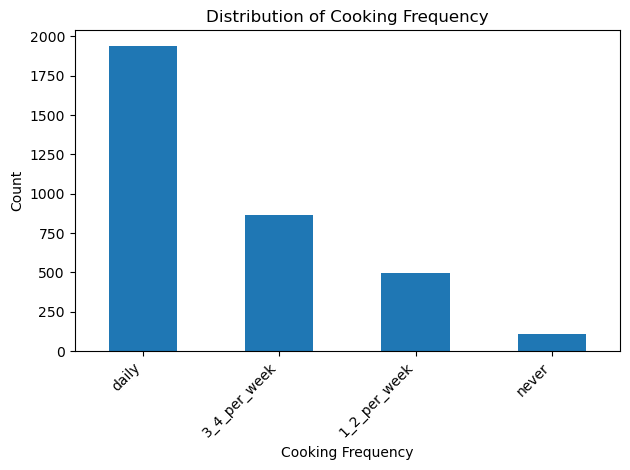

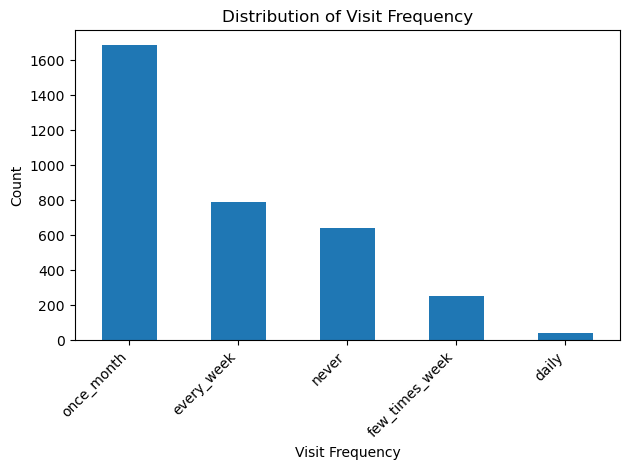

In [20]:
my_cat_cols = ['Country_cleaned', 'Province_cleaned', 'City_cleaned', 'Prefer Live With', 'Noise Tolerance', 'Cleaning Frequency', 'Cooking Frequency', 'Visit Frequency']

for col in my_cat_cols:
    # fill missing so they show up in the chart
    top = df[col].value_counts().head(10)

    plt.figure()
    top.plot.bar()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()